### 1. 目标定义
找出影响乘客生还率的若干特征，并利用机器学习算法构建生还率预测模型

### 2. 数据获取

In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train=pd.read_csv('train.csv',dtype={'Age':np.float64})
test=pd.read_csv('test.csv',dtype={'Age':np.float64})
print('train data:', train.shape, '\ntest data:', test.shape)

all=pd.concat([train, test], ignore_index=True)
print('all data:', all.shape)

print('train data:')
train.info()
print('-'*40)
print('test data:')
test.info()
print('-'*40)
print('all data:')
all.info()

train data: (891, 12) 
test data: (418, 11)
all data: (1309, 12)
train data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
test data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp  

In [3]:
all.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


### 3. 数据预处理
这一部分主要是对数据进行清洗，缺失值/异常点处理，特征衍生，同时也对单变量进行描述性统计

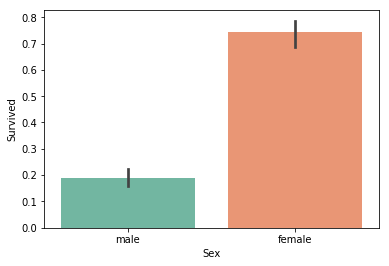

In [4]:
#数据可视化，可以帮助理解生还率对不同变量的分布情况
#性别，女性生还率远高于男性
sns.barplot(x='Sex', y='Survived', data=train, palette='Set2') #sns.barplot()默认的estimator是mean，也就是生还率

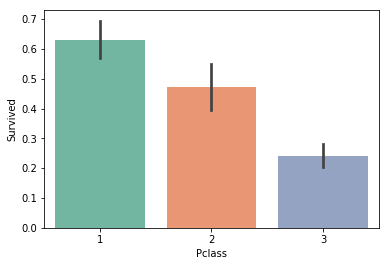

In [5]:
#Pclass，船舱等级越高，生还率越高
sns.barplot(x='Pclass', y='Survived', data=train, palette='Set2')

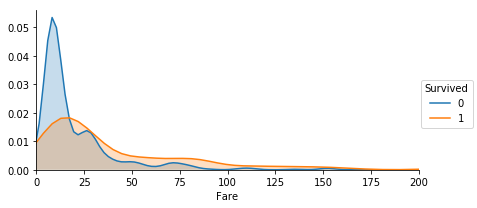

In [6]:
#Fare, 船票价格越高，生还率会越高
all['Fare'].fillna(all['Fare'].mean(), inplace=True)
facet=sns.FacetGrid(train, hue='Survived', aspect=2)
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, 200))
facet.add_legend()

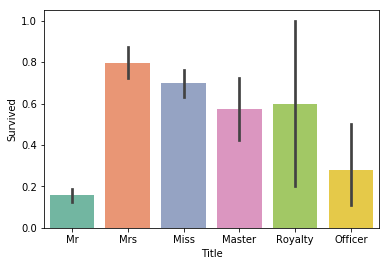

In [7]:
#Title，‘Mr'生还率最低，’Mrs‘生还率最高
all['Title']=all['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
Title_Dict={}
Title_Dict.update(dict.fromkeys(['Capt','Col','Major','Dr','Rev'],'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady','Jonkheer'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master'], 'Master'))
all['Title']=all['Title'].map(Title_Dict)
sns.barplot(x='Title',y='Survived', data=all, palette='Set2')

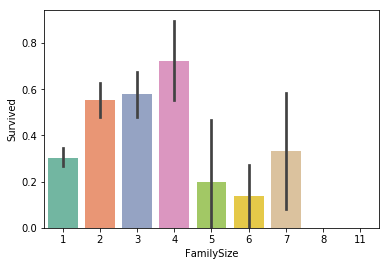

In [8]:
#FamilySize
all['FamilySize']=all['SibSp']+all['Parch']+1
sns.barplot(x='FamilySize', y='Survived', data=all, palette='Set2')

FamilyLabel
0    0.303538
1    0.578767
2    0.161290
Name: Survived, dtype: float64


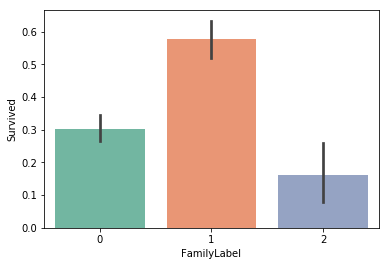

In [9]:
#将FamilySize标签化
def family_label(s):
    if s==1:
        return 0
    elif (s>1) & (s<=4):
        return 1
    else:
        return 2
all['FamilyLabel']=all['FamilySize'].apply(family_label)
print(all.groupby(['FamilyLabel'])['Survived'].mean())
sns.barplot(x='FamilyLabel', y='Survived', data=all, palette='Set2')

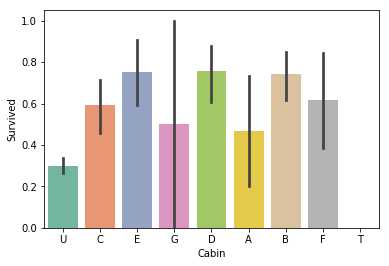

In [10]:
#Cabin
#将缺失值填充为’Unknown‘
all['Cabin']=all['Cabin'].fillna('Uknown')
all['Cabin']=all['Cabin'].str.get(0)
sns.barplot(x='Cabin', y='Survived', data=all, palette='Set2')

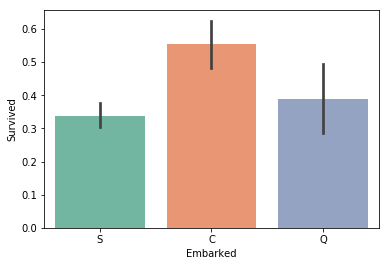

In [11]:
#Embarked
#先用众数填充Embarked缺失值
Em_mode=all['Embarked'].mode()[0]
all['Embarked'].fillna(Em_mode, inplace=True)

sns.barplot(x='Embarked', y='Survived', data=train, palette='Set2')

In [12]:
#随机森林法处理Age缺失值
from sklearn.ensemble import RandomForestRegressor
age_df=all[['Age','Title','Sex','Pclass','SibSp','Parch']]
age_df=pd.get_dummies(age_df)
age_df_known=age_df.loc[(age_df['Age'].notnull())].as_matrix()
age_df_unknown=age_df.loc[(age_df['Age'].isnull())].as_matrix()
X=age_df_known[:,1:]
Y=age_df_known[:,0]

RFR=RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
RFR.fit(X,Y)
predictAges=RFR.predict(age_df_unknown[:,1:])
all.loc[all['Age'].isnull(),['Age']]=predictAges

In [13]:
#查看缺失值处理之后的整体数据
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
FamilySize     1309 non-null int64
FamilyLabel    1309 non-null int64
dtypes: float64(3), int64(6), object(6)
memory usage: 153.5+ KB


In [14]:
#特征工程
#需要转换成哑变量
corrDF=pd.get_dummies(all.drop(['Name','PassengerId','Ticket','FamilySize'],axis=1)).corr() 
corrDF

,Age,Fare,Parch,Pclass,SibSp,Survived,FamilyLabel,Cabin_A,Cabin_B,Cabin_C,...,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
Age,1.000000,0.182494,-0.143680,-0.435095,-0.261008,-0.058622,-0.197900,0.138917,0.118254,0.186006,...,-0.067544,-0.031888,-0.074247,0.074247,-0.394387,-0.304128,0.193779,0.231442,0.166849,0.058207
Fare,0.182494,1.000000,0.221522,-0.558477,0.160224,0.257307,0.287672,0.020094,0.393743,0.401370,...,-0.130054,-0.169894,0.185484,-0.185484,0.011596,0.092051,-0.192192,0.139235,0.028696,0.026214
Parch,-0.143680,0.221522,1.000000,0.018322,0.373587,0.081629,0.687001,-0.030707,0.073051,0.009601,...,-0.100943,0.071881,0.213125,-0.213125,0.253482,0.066473,-0.304780,0.213491,-0.032631,-0.030197
Pclass,-0.435095,-0.558477,0.018322,1.000000,0.060832,-0.338481,-0.067487,-0.202143,-0.353414,-0.430044,...,0.230491,0.091320,-0.124617,0.124617,0.095257,0.024487,0.121492,-0.179945,-0.137341,-0.104916
SibSp,-0.261008,0.160224,0.373587,0.060832,1.000000,-0.035322,0.750411,-0.039808,-0.011569,0.048616,...,-0.048678,0.073709,0.109609,-0.109609,0.329171,0.077564,-0.243104,0.061643,-0.013813,-0.010787
Survived,-0.058622,0.257307,0.081629,-0.338481,-0.035322,1.000000,0.108631,0.022287,0.175095,0.114652,...,0.003650,-0.149683,0.543351,-0.543351,0.085221,0.332795,-0.549199,0.344935,-0.031316,0.033391
FamilyLabel,-0.197900,0.287672,0.687001,-0.067487,0.750411,0.108631,1.000000,-0.049594,0.075694,0.110577,...,-0.109111,0.025734,0.258533,-0.258533,0.332009,0.052191,-0.386111,0.288932,-0.024352,-0.013966
Cabin_A,0.138917,0.020094,-0.030707,-0.202143,-0.039808,0.022287,-0.049594,1.000000,-0.029886,-0.036366,...,-0.042105,-0.056984,-0.047561,0.047561,-0.000711,-0.035697,0.015372,-0.039005,0.072981,0.167091
Cabin_B,0.118254,0.393743,0.073051,-0.353414,-0.011569,0.175095,0.075694,-0.029886,1.000000,-0.063580,...,-0.073613,-0.095790,0.094453,-0.094453,-0.017168,0.035069,-0.096776,0.078868,0.049729,0.036551
Cabin_C,0.186006,0.401370,0.009601,-0.430044,0.048616,0.114652,0.110577,-0.036366,-0.063580,1.000000,...,-0.059151,-0.101861,0.077473,-0.077473,-0.047456,-0.013418,-0.068072,0.112164,0.052889,0.024932


In [15]:
#按相关系数绝对值降序排列
corrDF['Survived'].abs().sort_values(ascending=False)

Survived         1.000000
Title_Mr         0.549199
Sex_male         0.543351
Sex_female       0.543351
Title_Mrs        0.344935
Pclass           0.338481
Title_Miss       0.332795
Cabin_U          0.316912
Fare             0.257307
Cabin_B          0.175095
Embarked_C       0.168240
Cabin_D          0.150716
Embarked_S       0.149683
Cabin_E          0.145321
Cabin_C          0.114652
FamilyLabel      0.108631
Title_Master     0.085221
Parch            0.081629
Age              0.058622
Cabin_F          0.057935
SibSp            0.035322
Title_Royalty    0.033391
Title_Officer    0.031316
Cabin_T          0.026456
Cabin_A          0.022287
Cabin_G          0.016040
Embarked_Q       0.003650
Name: Survived, dtype: float64

In [16]:
#选择corr大于0.1的特征
all_X=pd.get_dummies(all[['Title','Sex','Pclass','FamilyLabel','Fare','Cabin','Embarked']])
all_X.head()

,Pclass,FamilyLabel,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Sex_female,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,3,1,7.2500,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,1,71.2833,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,3,0,7.9250,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1,1,53.1000,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,3,0,8.0500,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


### 4. 模型构建 及 5. 模型评估

In [17]:
#建立训练集
sourceRow=891
source_X=all_X.iloc[0:sourceRow-1]
source_y=all.iloc[0:sourceRow-1]['Survived']

pred_X=all_X.iloc[sourceRow::]

In [18]:
#建模与优化
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#训练集与测试集划分
train_X, test_X, train_y, test_y= train_test_split(source_X,source_y,train_size=0.8, random_state=5)
#选择逻辑回归和随机森林法两个分类器
model1=LogisticRegression()
model2=RandomForestClassifier()

models=[model1,model2]
scores=[]
for model in models:
    model.fit(train_X,train_y)
    scores.append(model.score(test_X, test_y))
print(scores)  

[0.8370786516853933, 0.8314606741573034]


In [19]:
#对不同的分类器进行加权平均，得到最终的预测模型
pred_y=(model1.predict(pred_X)+model2.predict(pred_X))/2

In [20]:
#将概率转换成0，1值
def func(x):
    if x>0.5:
        return 1
    else: 
        return 0
vfunc=np.vectorize(func)
pred_y=vfunc(pred_y)

### 6. 方案实施

In [21]:
#将预测结果导出
passenger_id=all.loc[sourceRow:, 'PassengerId']
prediction=pd.DataFrame({'PassengerId': passenger_id, 'Survived': pred_y})
prediction.to_csv('my_pred.csv', index=False)
prediction.shape

(418, 2)